# **DATA EXPLORATION AND PREPROCESSING**


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/content/Churn_Modelling.csv')

In [3]:
df.shape

(10000, 14)

In [4]:
df.isnull().sum()

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


In [5]:
df.duplicated().sum()

np.int64(0)

Dropping features which doesn't impact the model's prediction
1. CustomerId - CustomerId is just a column which represents the unique identification of bank customers. Since it is only for the identification it doesn't impact the final prediction/accuracy
2. Surname - Surname represents another name of customers which also doesn't involve in the model's prediction.
3. RowNumber - Rownumber indicates the number of rows in the dataset.

In [6]:
df.drop(['CustomerId'], axis=1, inplace=True)

In [7]:
df.drop(['Surname'], axis=1, inplace=True)

In [8]:
df.drop(['RowNumber'], axis=1, inplace=True)

Dispaly the first 5 rows after dropping the columns which are not highly correlated.

In [9]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# **Feature Engineering**
Feature Engineering is the process of selecting and improving the input fetures to improve the performance of the machine learning model.
1. Machine Learning model does not understand the categorical columns so encode the geography.


In [12]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
#encode Geography
df = pd.get_dummies(df, columns=["Geography"], drop_first=True)

#Encode Gender
le = LabelEncoder()
df["Gender"] = le.fit_transform(df["Gender"])

# **MODEL BUILDING**

In [13]:
X = df.drop("Exited", axis=1)
y = df["Exited"]

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

The dataset shows class imbalance, with churn being a minority class. Since churn directly impacts revenue, the model should prioritize recall for churn customers rather than overall accuracy. This enables better business decision-making.

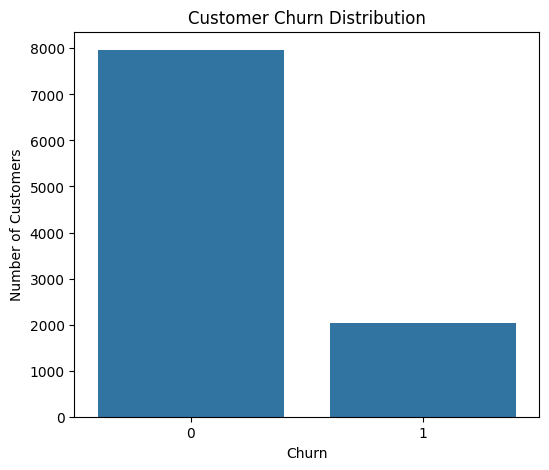

In [36]:
plt.figure(figsize=(6,5))

sns.countplot(x=df["Exited"])

plt.title("Customer Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Number of Customers")

plt.show()

# **HANDLING CLASS IMBALANCE**
# **SYNTHETIC MINORITY OVERSAMPLING TECHNIQUE**
1.SMOTE is the process which balances the dataset such that the model is not biased. In this dataset the actual churn rate is just 20% which clearly indicates that the data is biased towards the non churn customers.

2.In order to handle this imbalanced data I've used the technique called SMOTE which creates a synthetic data based on the neighbors and balances the data.

Before SMOTE technique the actual churned customer is 1630 and non churned customer is 6370. Even if the model gives the higher accuracy the perfomance of the model decreases due to the class imbalance.

This class imbalance should be handled carefully inorder to avoid the biased model.There comes the SMOTE technique for handling the imbalanced data.

After the SMOTE technique the customer churn becomes 6370 equals to the non churn customer.This ensures that the model is not biased towards the non churn data that might affect the prediction of the model.

In [15]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())

Before SMOTE: Exited
0    6370
1    1630
Name: count, dtype: int64
After SMOTE: Exited
1    6370
0    6370
Name: count, dtype: int64


In [16]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# **LOGISTIC REGRESSION**
Logistic Regression is the classification machine learning algorithm which is used in the binary classification which is easy to implement.Since it's a linear model it is less complex
and works well when dataset is not very large

In [17]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight="balanced", max_iter=1000)
lr.fit(X_train_scaled, y_train_smote)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:,1]


Text(45.722222222222214, 0.5, 'Actual')

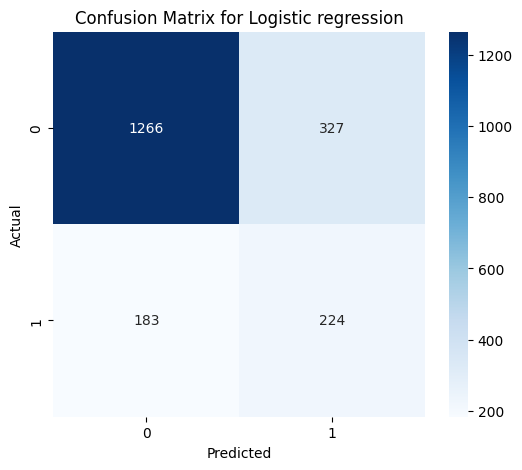

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Logistic regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")

From the confusion matrix (Logistic Regression):
*   True Negatives (TN) = 1266
→ Correctly predicted non-churn


*   False Positives (FP) = 327→ Predicted churn but actually stayed
*   False Negatives (FN) = 183→ Predicted stay but actually churned


*   True Positives (TP) = 224→ Correctly predicted churn


183 customers who actually churned were predicted as non-churn.
This means the company fails to identify some customers who are about to leave.

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

print("Logistic Regression Report:\n")
print(classification_report(y_test, y_pred_lr))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob_lr))

Logistic Regression Report:

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1593
           1       0.41      0.55      0.47       407

    accuracy                           0.74      2000
   macro avg       0.64      0.67      0.65      2000
weighted avg       0.78      0.74      0.76      2000

ROC AUC Score: 0.746276322547509


# **RANDOM FOREST**
Logistic Regression assumes:

Linear relationship between features. But real-world churn data:
has complex interactions, non-linear relationships
Random Forest handles this better.

Random Forest Handles Non-Linearity in the input fetures. It builds multiple decision trees and captures complex patterns works well with mixed feature types


In [19]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200,class_weight="balanced",random_state=42
)
rf.fit(X_train_smote, y_train_smote)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]



Text(45.722222222222214, 0.5, 'Actual')

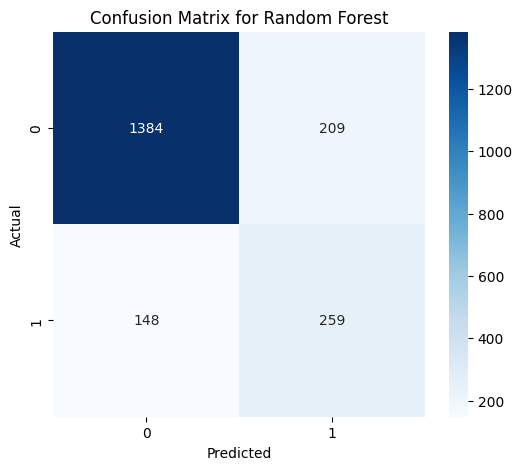

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")

From the Random Forest confusion matrix:



*   True Negatives (TN) = 1384→ Correctly predicted non-churn
*   False Positives (FP) = 209→ Predicted churn but actually stayed

*   False Negatives (FN) = 148→ Predicted stay but actually churned
*  True Positives (TP) = 259→ Correctly predicted churn


Compared to Logistic Regression:

FN reduced from 183 → 148

TP increased from 224 → 259

*The model is now identifying more actual churn customers

In [27]:
print("Random Forest Report:\n")
print(classification_report(y_test, y_pred_rf))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob_rf))


Random Forest Report:

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      1593
           1       0.55      0.64      0.59       407

    accuracy                           0.82      2000
   macro avg       0.73      0.75      0.74      2000
weighted avg       0.83      0.82      0.83      2000

ROC AUC Score: 0.845146379044684


The top 5 important features which contributes to the model's prediction is as follows
  

1.   Age
2.   Whether is customer is active or not
3.   Customers credit score
4.  Customer's account balance



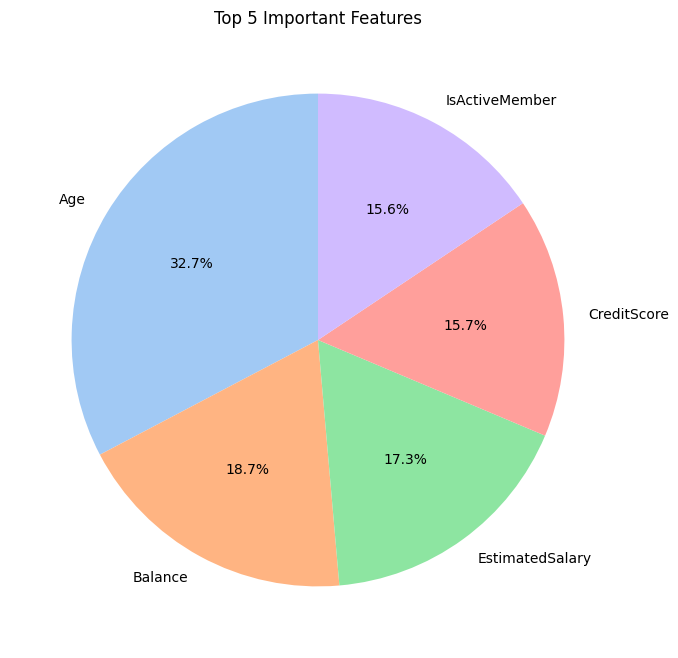

In [31]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,8))
plt.pie(feature_importance['Importance'][:5], labels=feature_importance['Feature'][:5],
        autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Top 5 Important Features')
plt.show()